<a href="https://colab.research.google.com/github/ceccaroni1884368/Face-to-BMI/blob/main/Face_To_BMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install autocrop -q
! pip install facenet-pytorch -q

     |████████████████████████████████| 163kB 12.5MB/s 
     |████████████████████████████████| 1.9MB 8.6MB/s 


In [2]:
import os
from bs4 import BeautifulSoup
import requests
import autocrop
from tqdm import tqdm
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import autocrop
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1

# Dataset

In [3]:
with open(os.path.join('.', 'pages_list.txt')) as f:
    pages_list = f.read().splitlines()

output_dir = os.path.join('.', 'dataset')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
images = []
heights = []
weights = []

for i in tqdm(range(len(pages_list))):
    html_page = requests.get(pages_list[i])
    soup = BeautifulSoup(html_page.text, "html.parser")

    # image
    for x in soup.findAll('img'):
        if '.jpg' in x['src']:
            images.append(x['src'])
            break

    # height and weight
    h = False
    w = False
    for x in soup.findAll('td'):
        if h:
            heights.append(float(x.text.split()[0]))
        if w:
            weights.append(float(x.text.split()[0]))

        if 'Height' in x.text:
            h = True
            w = False 
        elif 'Weight' in x.text:
            h = False
            w = True
        else:
            h = False
            w = False
            
    l = min([len(images), len(heights), len(weights)])
    images = images[:l]
    heights = heights[:l]
    weights = weights[:l]

 83%|████████▎ | 1654/2001 [17:26<03:31,  1.64it/s]

In [ ]:
df = pd.DataFrame({'image':images, 'height (cm)': heights, 'weight (kg)': weights})
df.head()

In [9]:
images_path = os.path.join(output_dir, 'images')
if not os.path.exists(images_path):
    os.makedirs(images_path)

for image in tqdm(df['image']):
    response = requests.get(image)

    file = open(os.path.join(output_dir, 'images',image.split('/')[-1].split('_')[0]+ '.jpg'), "wb")
    file.write(response.content)
    file.close()

100%|██████████| 1973/1973 [02:23<00:00, 13.72it/s]


In [10]:
df['image'] = df['image'].apply(lambda x: x.split('/')[-1].split('_')[0] + '.jpg')

In [11]:
with open(os.path.join('.', 'list_images.txt')) as f:
    list_images = f.read().splitlines()

In [12]:
df = df[df['image'].isin(list_images)]
df = df.reset_index(drop=True)
df.to_csv(os.path.join(output_dir, 'df.csv'), index=False)

In [13]:
df = pd.read_csv(os.path.join(output_dir, 'df.csv'))

In [16]:
df['BMI'] = df['weight (kg)'] / (df['height (cm)'] /100)**2
df.head()

,image,height (cm),weight (kg),BMI
0,1491379716.jpg,167.0,66.0,23.665244
1,1533303278.jpg,163.0,58.0,21.829952
2,1533305289.jpg,166.0,56.0,20.322253
3,1533306129.jpg,168.0,54.0,19.132653
4,1533306989.jpg,180.3,84.0,25.839722


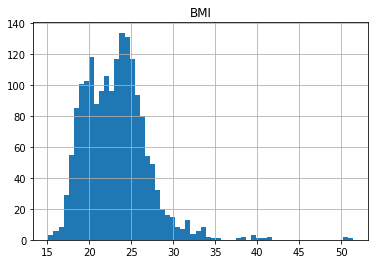

In [17]:
df[['BMI']].hist(bins=60)
plt.show()

In [18]:
def bmi_classification(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif (bmi >= 18.5) and (bmi < 25):
        return 'normal'
    elif (bmi >= 25) and (bmi < 30):
        return 'overweight'
    elif (bmi >= 30) and (bmi < 35):
        return 'moderately obese'
    elif (bmi >= 35) and (bmi < 40):
        return 'severely obese'
    else:
        return 'very severely obese'

In [19]:
df['class'] = df['BMI'].apply(bmi_classification)

In [27]:
df['class'].value_counts()

normal                 1167
overweight              427
underweight             152
moderately obese         56
very severely obese       7
severely obese            7
Name: class, dtype: int64

In [82]:
mtcnn = MTCNN()
model = InceptionResnetV1(pretrained='vggface2', classify=False).eval()

In [83]:
images_features = []
for img in df['image'].apply(lambda x: os.path.join(images_path, x)):
    img = Image.open(img)

    # Get cropped and prewhitened image tensor
    img_cropped = mtcnn(img)

    # Calculate embedding (unsqueeze to add batch dimension)
    img_embedding = model(img_cropped.unsqueeze(0))

    images_features.append(img_embedding.detach().cpu().numpy().flatten())

df_new = pd.DataFrame(images_features)
df_new['target'] = df['BMI']
df_new.to_csv(os.path.join(output_dir, 'df_features.csv'), index=False)

In [ ]:
df_new = pd.read_csv(os.path.join(output_dir, 'df_features.csv'))